# Lab 4 (Feb 9): Kernel Method

This week, we will apply kernel method to support vector machine, which allows us to generate non-linear separation boundary line.

Data set $\{x_i,y_i\}$ cannot be linearly separated in a lower-dimensional vector space $\mathbb{R}^n$, while it can be linearly separated in a higher-dimensional vector space $\mathbb{R}^N$, $n\leq N$. 

So we first introduce feature map $\phi:\mathbb{R}^n \to \mathbb{R}^N$ that maps $x_i$ to $\phi(x_i)\in\mathbb{R}^N$. Then we apply support vector machine for new data set $\{\phi(x_i),y_i\}$.

Computation in $\mathbb{R}^N$ is the main difficulty. It's addressed by introducing kernel function that gives us a simple way to compute the inner product in $\mathbb{R}^N$.
$$ K(x_i,x_j) = \langle \phi(x_i),\phi(x_j) \rangle $$

Recall support vector machine, we try to find $w\in\mathbb{R}^N$ and $b\in\mathbb{R}$. According to the textbook, $w = \sum_{j=1}^{m}a_j\phi(x_j)$ for some $a\in\mathbb{R}^m$.

The desired $a\in\mathbb{R}^m$ and $b\in\mathbb{R}$ are the solution to the following optimization program
$$ \mathop{\mathrm{minimize}}_{a\in\mathbb{R}^m, b\in\mathbb{R},\xi\in\mathbb{R}^m} a^\top Ka + \frac{1}{\lambda}\sum_{i=1}^{m}\xi_i \quad \mbox{ s.to } \quad y_i((Ka)_i-b)\geq1 \quad  \mbox{ for all } i\in[1 : m],$$
where $K_{i,j} = K(x_i,x_j) = \langle \phi(x_i),\phi(x_j) \rangle$.

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import cvxpy as cp

The next function implements above optimization problem using CVXPY. 

In [2]:
def kernel_svm(K,lamb,m0,m1):
    
    ## K is the kernel matrix.
    ## Hyperparameter lamb needs to be chosen carefully.
    ## m0 is the number of data points with label y = -1
    ## m1 is the number of data points with label y = +1
    
    # define the variables a\in R^m, b\in R and xi\in R^m (m = m0+m1)
    a = cp.Variable(m0+m1)
    b = cp.Variable(1)
    xi = cp.Variable(m0+m1,pos=True)
    
    # define the objective function
    objective = cp.Minimize(cp.quad_form(a,K)+cp.sum(xi)/lamb)
    
    # define the inequality constraints
    # First m0 costraints correspond to class with label -1
    # Next m1 constraints correspond to class with label +1
    constraints = [K[0:m0,:]@a - b <= -1+xi[0:m0]]
    constraints += [K[m0:m0+m1,:]@a - b >= 1-xi[m0:m0+m1]]
    
    # solve optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver='ECOS')
    
    # return the outputs
    return a.value, b.value

## Explaination of polynomial kernel

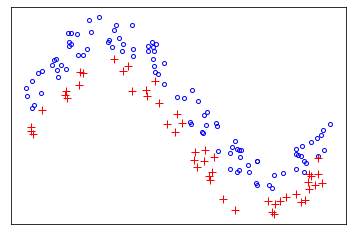

In [3]:
np.random.seed(1)
m0 = 100;
m1 = 50;

# The first coordinate of X0
X0_x = np.random.uniform(0,6,m0)
# The second coordinate of X0
X0_y = np.sin(X0_x) + np.random.uniform(0,0.5,m0) 
# Stack first and second coordinate to obatin X0
X0 = np.column_stack( (X0_x, X0_y) )
    
# The first coordinate of X1
X1_x = np.random.uniform(0,6,m1) 
# The second coordinate of X1
X1_y = np.sin(X1_x) - np.random.uniform(0,0.5,m1)
# Stack first and second coordinate to obtain X1
X1 = np.column_stack( (X1_x, X1_y) )

X = np.row_stack((X0,X1))
    
# Visualize data
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+', markerfacecolor='none',markersize=8)
plt.xticks([])
plt.yticks([])
plt.show()

The next function computes the kernel matrix corresponding to polynomial kernel of degree d, which is computed by
$$ K(x,y) = (1+\langle x,y\rangle)^d, \quad \mbox{ for all } x,y\in\mathbb{R}^n.$$

In [4]:
def poly_kernel(X,d):
    
    # X is data matrix; d is the degree of polynomial kernel.

    # Compute kernel matrix K (Hint: matrix transpose helps a lot, using loop is slow)
    K = (1+X@X.T)**d
    
    return K

In [5]:
# Compute the kernel matrix K_poly
d = 3
K_poly = poly_kernel(X,d)

# Compute the optimization problem to get a\in R^m and b\in R
lamb = 1e-3
a_poly,b_poly = kernel_svm(K_poly,lamb,m0,m1)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var0, [[4.81594253e+02 1.44730855e+03 2.40036850e+00 ... 4.60085634e+02
  1.06452878e+03 2.85831620e+03]
 [1.44730855e+03 8.14052689e+03 3.57328265e-01 ... 1.53609508e+03
  7.37556089e+03 1.62750065e+04]
 [2.40036850e+00 3.57328265e-01 1.71435150e+00 ... 1.91587716e+00
  7.86161118e-02 2.79917207e-01]
 ...
 [4.60085634e+02 1.53609508e+03 1.91587716e+00 ... 4.47619706e+02
  1.18129271e+03 3.02902943e+03]
 [1.06452878e+03 7.37556089e+03 7.86161118e-02 ... 1.18129271e+03
  7.16351859e+03 1.46645725e+04]
 [2.85831620e+03 1.62750065e+04 2.79917207e-01 ... 3.02902943e+03
  1.46645725e+04 3.27646469e+04]])

In [ ]:
# visualize the boundary produced by SVM with the polynomial kernel
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
grid_x = np.linspace(0,6,100)
grid_y = np.linspace(-1.5,1.5,100)
xx,yy = np.meshgrid(grid_x,grid_y)
f = sum( ( a_poly[i] *(1+X[i,0]*xx+X[i,1]*yy)**3 for i in range(m0+m1) ) )  
plt.contour(grid_x,grid_y,f-b_poly,0, colors='k',linestyles='dashed')
plt.xticks([])
plt.yticks([])
plt.show()

## Explaination of Gaussian Kernel

The next function computes the kernel matrix of Gaussian kernel, which is computed by 
$$ K(x,y) = \exp(-\frac{\|x-y\|^2}{2\sigma^2}), \quad \mbox{ for all } x,y\in\mathbb{R}^n.$$

In [6]:
def gaussian_kernel(X,sigma):
    
    # X is data matrix; sigma is the paramter in Gaussian kernel
    
    # Compute kernel matrix K. Unfortunately, for loop is needed. 
    m = np.shape(X)[0]
    K = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            K[i,j] = np.exp(-LA.norm(X[i,:]-X[j,:])/(2*sigma**2))
    
    return K

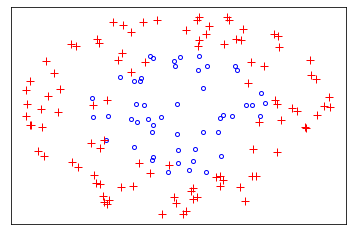

In [7]:
# generate the data
m0 = 50
m1 = 100
r0 = 1.1*np.sqrt(np.random.uniform(0,1,m0))
theta0 = np.random.uniform(0,2*np.pi,m0)
r1 = 0.8 + np.sqrt(np.random.uniform(0,1,m1))
theta1 = np.random.uniform(0,2*np.pi,m1)
X0 = np.column_stack( (r0*np.cos(theta0), r0*np.sin(theta0)) )
X1 = np.column_stack( (r1*np.cos(theta1), r1*np.sin(theta1)) )

X = np.row_stack((X0,X1))

plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
sigma = 1
K_gaus = gaussian_kernel(X,sigma)

lamb = 1
a_expo,b_expo = kernel_svm(K_gaus,lamb,m0,m1)

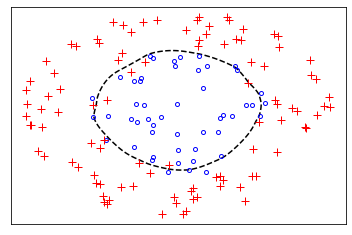

In [10]:
# visualize the boundary produced by SVM with the exponential kernel
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
grid_x = np.linspace(-1.5,1.5,100)
grid_y = np.linspace(-1.5,1.5,100)
xx,yy = np.meshgrid(grid_x,grid_y)
f = sum( ( a_expo[i] * np.exp( -np.sqrt((X[i,0]-xx)**2+(X[i,1]-yy)**2) / (2*sigma**2) ) for i in range(m0+m1) ) )
plt.contour(grid_x,grid_y,f-b_expo,0, colors='k',linestyles='dashed')
plt.xticks([])
plt.yticks([])
plt.show()